In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet("../../daily_weather.parquet")

### Looking into the data

In [3]:
df.head()

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,peak_wind_gust_kmh,avg_sea_level_pres_hpa,sunshine_total_min
0,41515,Asadabad,1957-07-01,Summer,27.0,21.1,35.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,41515,Asadabad,1957-07-02,Summer,22.8,18.9,32.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,41515,Asadabad,1957-07-03,Summer,24.3,16.7,35.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,41515,Asadabad,1957-07-04,Summer,26.6,16.1,37.8,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4,41515,Asadabad,1957-07-05,Summer,30.8,20.0,41.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(27635763, 14)

The data has 27M rows which is quite a lot, we will focus on just 5 cities to make things faster

In [5]:
df.city_name.unique()

['Asadabad', 'Fayzabad', 'Jalalabad', 'Kunduz', 'Qala i Naw', ..., 'Kasama', 'Livingstone', 'Mongu', 'Harare', 'Masvingo']
Length: 1235
Categories (1234, object): ['Aalborg', 'Abakan', 'Abha', 'Abidjan', ..., 'Ōita', 'Ōsaka', 'Şanlıurfa', 'Šibenik']

1234 Unique cities present in the data

In [8]:
df.city_name.isnull().sum()

np.int64(13993)

With about 14000 rows with missing city name

# EDA

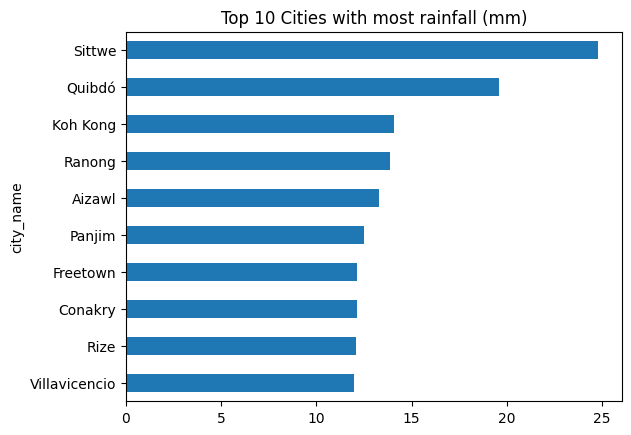

In [13]:
df.groupby('city_name')['precipitation_mm'].mean().sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Top 10 Cities with most rainfall (mm)');

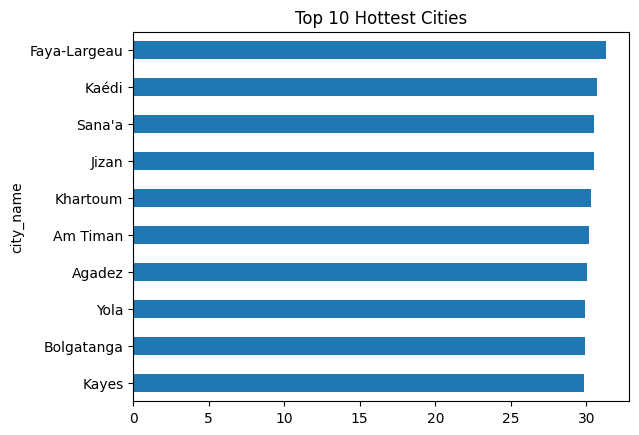

In [14]:
df.groupby('city_name')['avg_temp_c'].mean().sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Top 10 Hottest Cities');

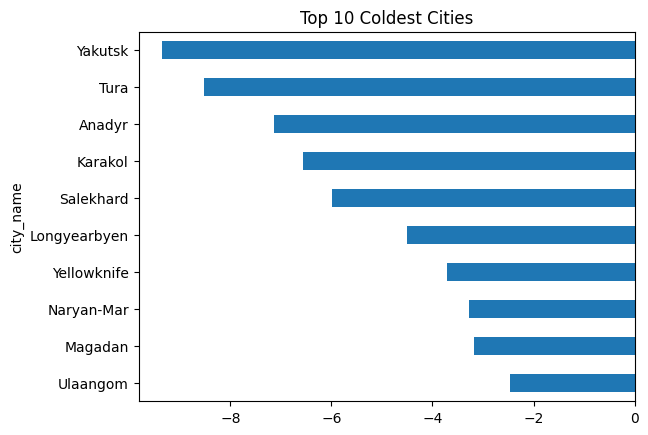

In [15]:
df.groupby('city_name')['avg_temp_c'].mean().sort_values(ascending=False).tail(10).plot(kind='barh')
plt.title('Top 10 Coldest Cities');

# Cleaning

In [17]:
df_mini = df[df.city_name.isin(['Abidjan', 'Toronto', 'Berlin', 'Kazan'])] # Select just 5 cities

In [18]:
df_mini['date'] = pd.to_datetime(df_mini['date'])

In [25]:
df_mini.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109265 entries, 0 to 51747
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   station_id              109265 non-null  category      
 1   city_name               109265 non-null  category      
 2   date                    109265 non-null  datetime64[us]
 3   season                  109265 non-null  category      
 4   avg_temp_c              109202 non-null  float64       
 5   min_temp_c              100508 non-null  float64       
 6   max_temp_c              99157 non-null   float64       
 7   precipitation_mm        96135 non-null   float64       
 8   snow_depth_mm           29039 non-null   float64       
 9   avg_wind_dir_deg        31672 non-null   float64       
 10  avg_wind_speed_kmh      35580 non-null   float64       
 11  peak_wind_gust_kmh      18062 non-null   float64       
 12  avg_sea_level_pres_hpa  36341 non-nu

We focus on average temperature and precipitation, as they provide the most reliable indicators for predicting whether it will rain and whether the weather will be hot or cool.

In [23]:
abidjan_data = df_mini[df_mini.city_name=='Abidjan'][['city_name', 'date', 'avg_temp_c','precipitation_mm']]
toronto_data = df_mini[df_mini.city_name=='Toronto'][['city_name', 'date', 'avg_temp_c','precipitation_mm']]
berlin_data = df_mini[df_mini.city_name=='Berlin'][['city_name', 'date', 'avg_temp_c','precipitation_mm']]
kazan_data = df_mini[df_mini.city_name=='Kazan'][['city_name', 'date', 'avg_temp_c','precipitation_mm']]

We'll handle missing values using forward fill, which fills a missing entry with the value from the previous row. This method is well-suited for time series data, as the weather on one day is often closely related to the weather on the day before.

In [8]:
abidjan_data[['avg_temp_c', 'precipitation_mm']] = abidjan_data[['avg_temp_c', 'precipitation_mm']].ffill()

In [9]:
abidjan_data.isnull().sum() # Check if all missing value has been filled

,0
city_name,0
date,0
avg_temp_c,0
precipitation_mm,116


There are still some missing values after applying forward fill, which likely means that the first few entries in the precipitation column were originally missing and had no prior values to fill from. We can perform a quick check to confirm this.

In [10]:
abidjan_data['precipitation_mm'][:116].isnull().sum() #It sums to 1 meaning the first 116 values are Null (True)

np.int64(116)

It's fine to drop these ones, it only extends the start date of the data there's no much downside other than that

In [26]:
abidjan_data = abidjan_data.dropna().reset_index(drop=True)

In [27]:
abidjan_data.isnull().sum() # Now all Good

city_name           0
date                0
avg_temp_c          0
precipitation_mm    0
dtype: int64

Let's do same for the remaining cities

In [13]:
toronto_data[['avg_temp_c', 'precipitation_mm']] = toronto_data[['avg_temp_c', 'precipitation_mm']].ffill()

In [14]:
toronto_data.isnull().sum()

,0
city_name,0
date,0
avg_temp_c,0
precipitation_mm,0


In [15]:
berlin_data[['avg_temp_c', 'precipitation_mm']] = berlin_data[['avg_temp_c', 'precipitation_mm']].ffill()

In [16]:
berlin_data.isnull().sum()

,0
city_name,0
date,0
avg_temp_c,0
precipitation_mm,0


In [17]:
kazan_data[['avg_temp_c', 'precipitation_mm']] = kazan_data[['avg_temp_c', 'precipitation_mm']].ffill()

In [18]:
kazan_data.isnull().sum()

,0
city_name,0
date,0
avg_temp_c,0
precipitation_mm,0


In [20]:
kazan_data.shape, abidjan_data.shape, berlin_data.shape, toronto_data.shape

((51748, 4), (17388, 4), (32280, 4), (7733, 4))

Let's do a quick check to see if all the days are available in our data

In [36]:
abidjan_data.date.max(), abidjan_data.date.min(), abidjan_data.shape

(Timestamp('2023-08-28 00:00:00'), Timestamp('1973-06-01 00:00:00'), (8742, 4))

In [34]:
full_range = pd.date_range(start='1973-06-01', end='2023-08-28')

In [35]:
len(full_range)

18351

There are 18,351 days between 1973-06-01 and 2023-08-28 (inclusive), but the abidjan_data DataFrame contains only 8,742 rows. This indicates that many days are missing from the dataset, which will influence how we approach modeling, particularly in handling gaps and ensuring time continuity.

quick check

In [38]:
len(set(full_range) - set(abidjan_data.date))

9609

In [39]:
18351 - 8742

9609

# Modelling

We will be using FBProphet for weather forecasting because it is well-suited for modeling time series data with strong seasonal patterns, which are inherent in weather behavior. Variables like temperature and precipitation often exhibit clear yearly, weekly, or even daily cycles, and Prophet is designed to capture such patterns effectively with minimal configuration.

Additionally, Prophet handles missing data, outliers, and non-linear trends. This solves the data gaps we noticed

By using Prophet, we can quickly generate reliable forecasts without extensive parameter tuning or complex preprocessing, making it a practical choice for this task.

In [24]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

In [46]:
def train_test_split(df, column_name, n=365):
    """
    split the data into train and test set
    df: dataframe name
    column_name: column to split in data frame
    n: number of days to split the data default is 365 days
    """
    #TODO instead of n being number of days make it a % of the data like 10%
    #OR it could be years

    df = df.rename(columns={'date':'ds', column_name:'y'})

    train_df, test_df = df[['ds','y']][:-n], df[['ds','y']][-n:]

    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

Create a function to split the data into train and test.. because it's a timeseries data we can't split randomly we need to ensure the test data is in the future.

In [47]:
abidjan_temp_train, abidjan_temp_test = train_test_split(abidjan_data, 'avg_temp_c')
abidjan_precip_train, abidjan_precip_test = train_test_split(abidjan_data, 'precipitation_mm')

Also we'll be building a different model for the temperature and precipitation, this will be simple because of time...

In [48]:
#check
abidjan_temp_train.shape, abidjan_temp_test.shape, abidjan_precip_train.shape, abidjan_precip_test.shape

((8377, 2), (365, 2), (8377, 2), (365, 2))

In [49]:
city_names = ['abidjan', 'toronto', 'berlin', 'kazan']

> Create model instance for each models for all the cities we're working with

> Store the data in a dict to easily access it

In [28]:
models = {}
dataset = {}
for city in city_names:
    models[city + '_temp_model'] = Prophet()
    models[city + '_precip_model'] = Prophet(seasonality_mode='multiplicative')
    dataset[city + '_temp_train'], dataset[city + '_temp_test'] = train_test_split(eval(city +'_data'), 'avg_temp_c')
    dataset[city + '_precip_train'], dataset[city + '_precip_test'] = train_test_split(eval(city +'_data'), 'precipitation_mm')

Train the prophet model and make forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/uh5oah_i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/wbmz3tzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71551', 'data', 'file=/tmp/tmpzkn9sirw/uh5oah_i.json', 'init=/tmp/tmpzkn9sirw/wbmz3tzk.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_models46j08v4/prophet_model-20250526120227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


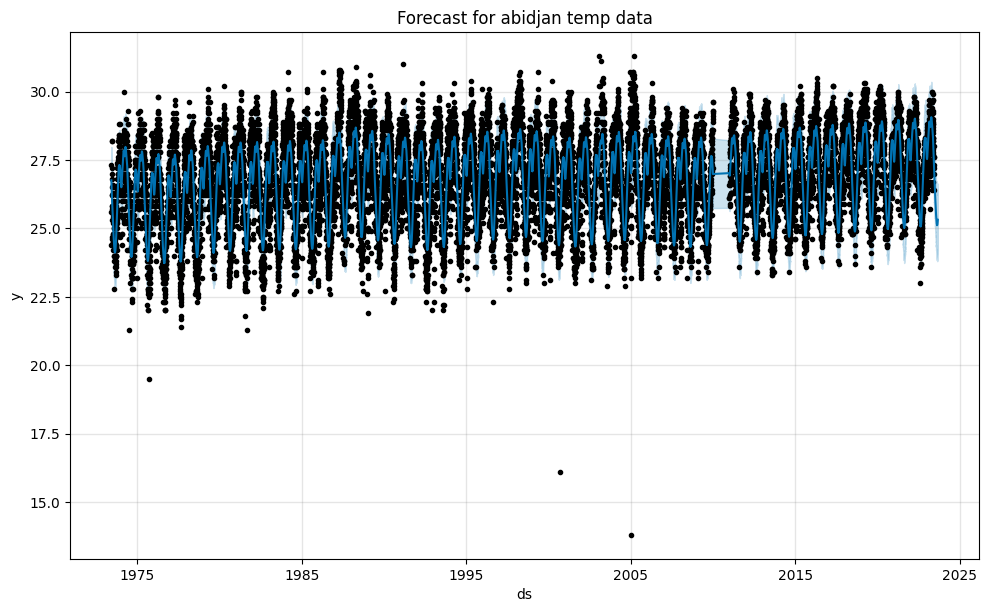

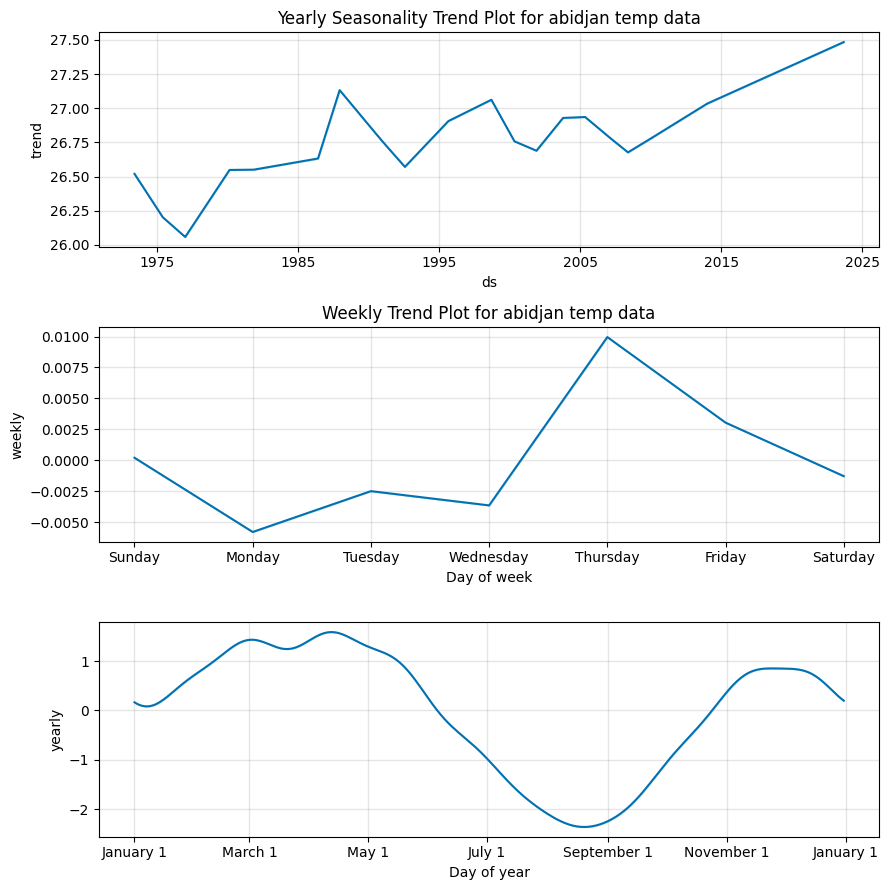

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/r6_6bmkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/nyrt7bji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43178', 'data', 'file=/tmp/tmpzkn9sirw/r6_6bmkx.json', 'init=/tmp/tmpzkn9sirw/nyrt7bji.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_modelum_i044m/prophet_model-20250526120239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


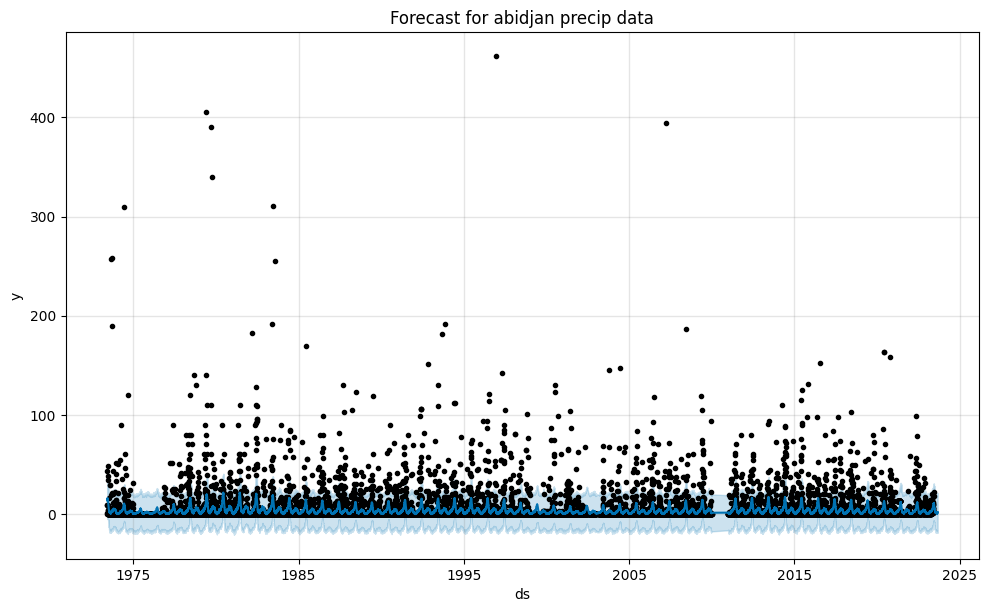

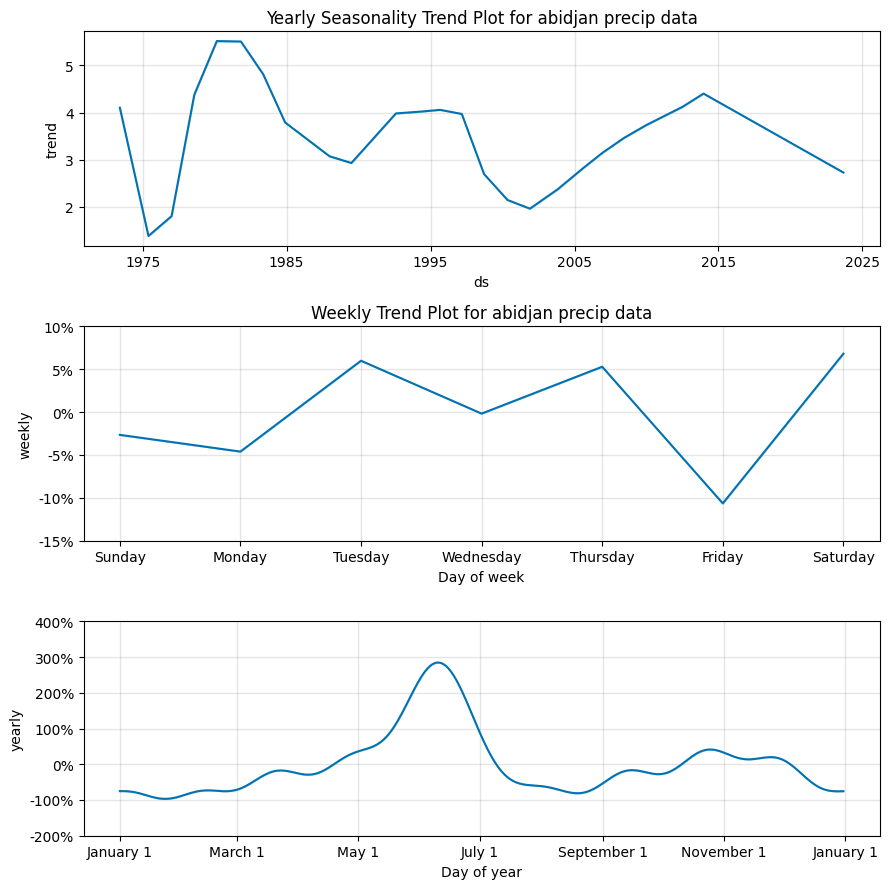

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/wyv2sp0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/mlycwntu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87595', 'data', 'file=/tmp/tmpzkn9sirw/wyv2sp0s.json', 'init=/tmp/tmpzkn9sirw/mlycwntu.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_modelw99vhu6e/prophet_model-20250526120247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


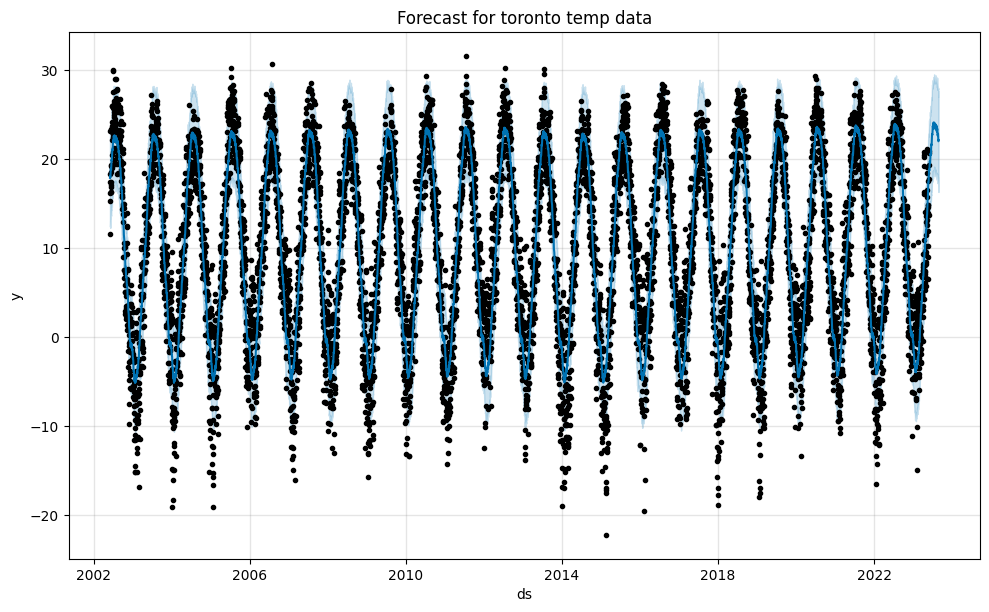

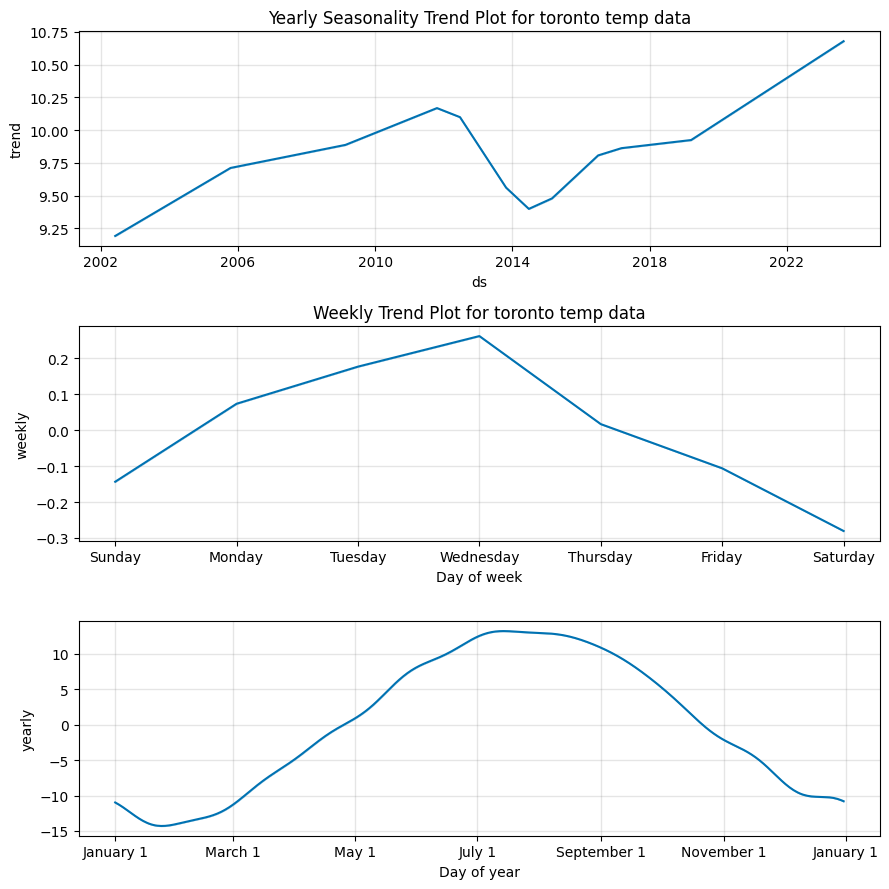

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/th9l6het.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/zfqmge_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47647', 'data', 'file=/tmp/tmpzkn9sirw/th9l6het.json', 'init=/tmp/tmpzkn9sirw/zfqmge_t.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_modelfzk15lw3/prophet_model-20250526120252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


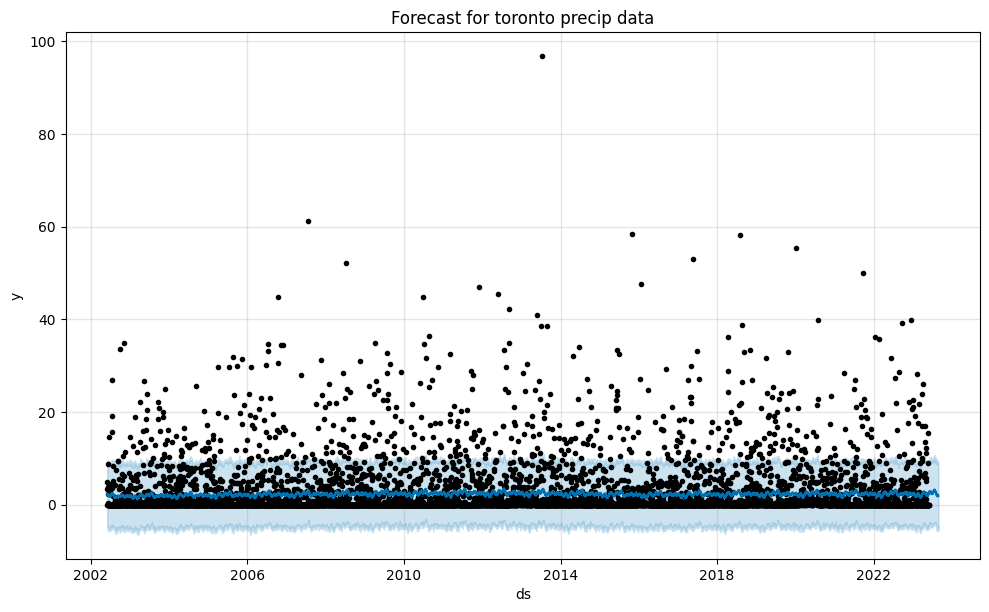

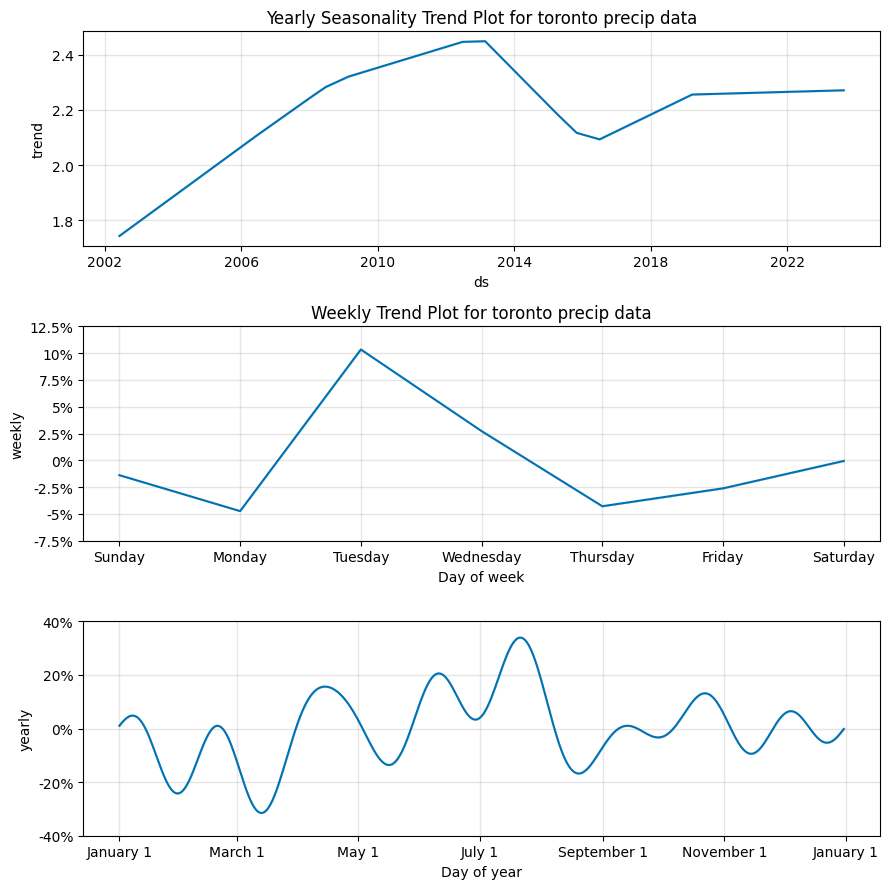

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/_y0lg6sy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/rdzvd228.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53689', 'data', 'file=/tmp/tmpzkn9sirw/_y0lg6sy.json', 'init=/tmp/tmpzkn9sirw/rdzvd228.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_modeljl6f6z86/prophet_model-20250526120257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


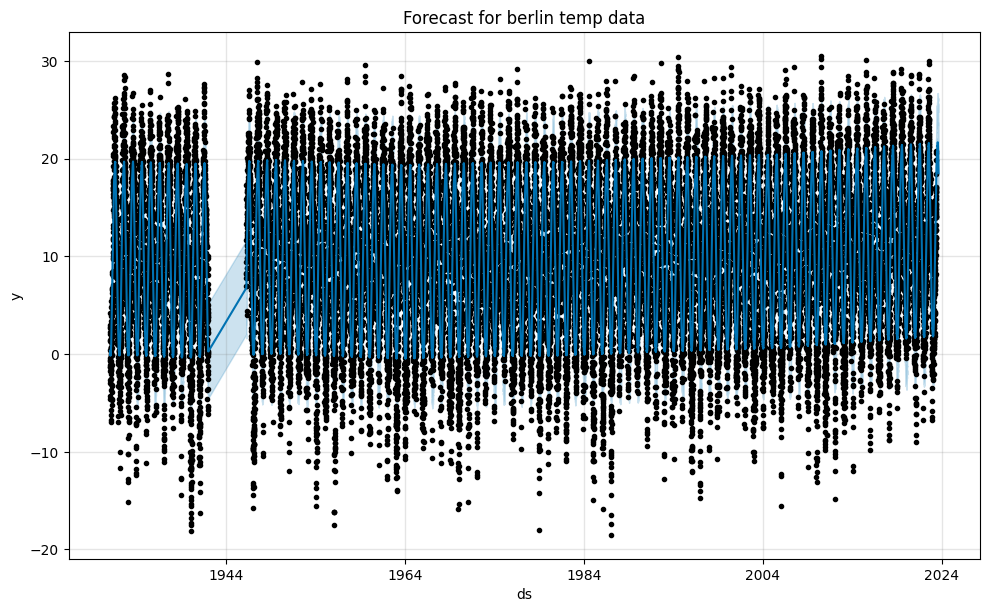

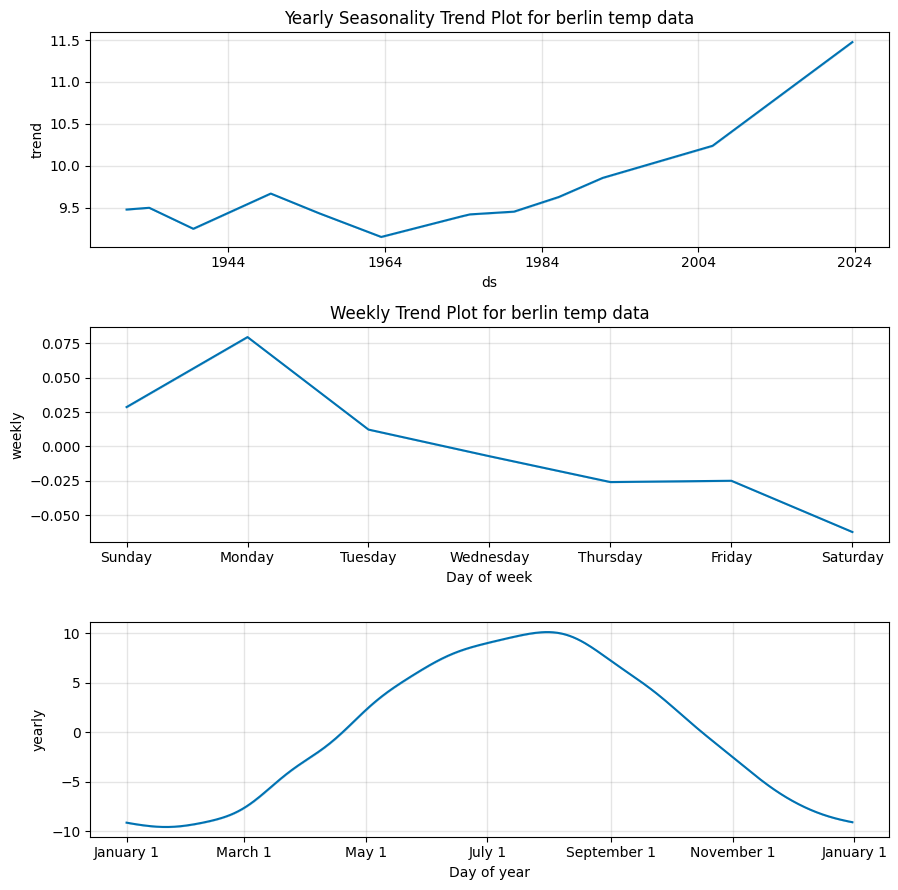

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/pssxpdxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/ka0q00rj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8423', 'data', 'file=/tmp/tmpzkn9sirw/pssxpdxu.json', 'init=/tmp/tmpzkn9sirw/ka0q00rj.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_modelm00w6hl1/prophet_model-20250526120315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:03:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


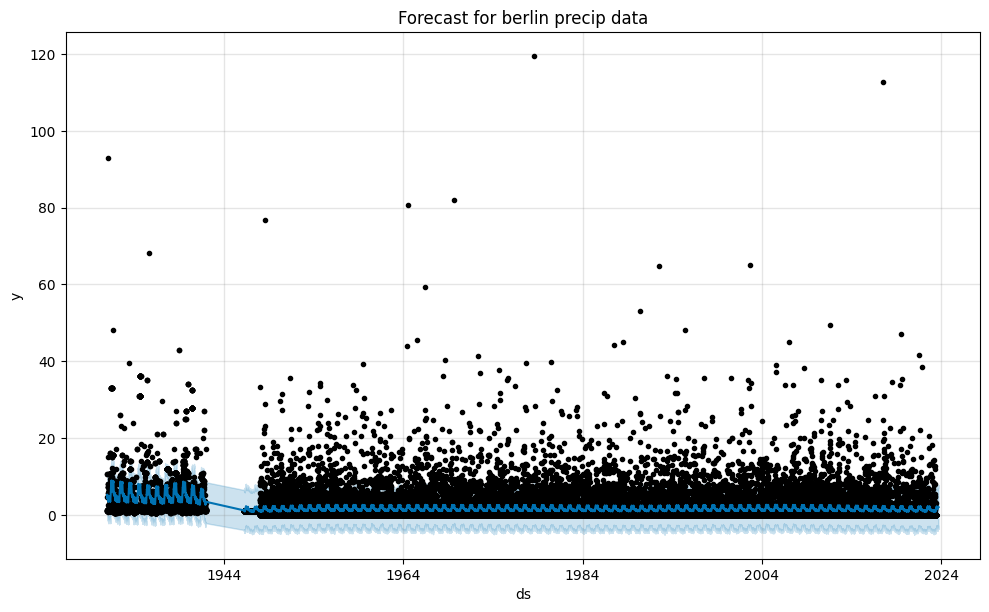

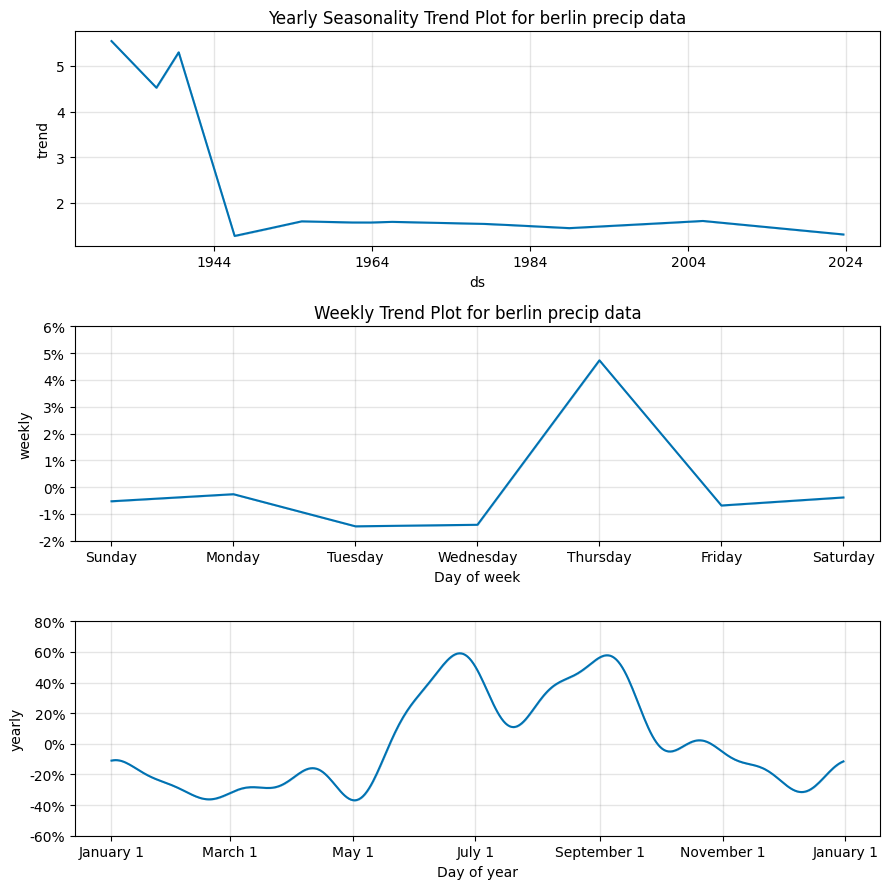

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/8596g640.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/66jn7wgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8857', 'data', 'file=/tmp/tmpzkn9sirw/8596g640.json', 'init=/tmp/tmpzkn9sirw/66jn7wgh.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_model11dl371x/prophet_model-20250526120345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:03:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:04:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


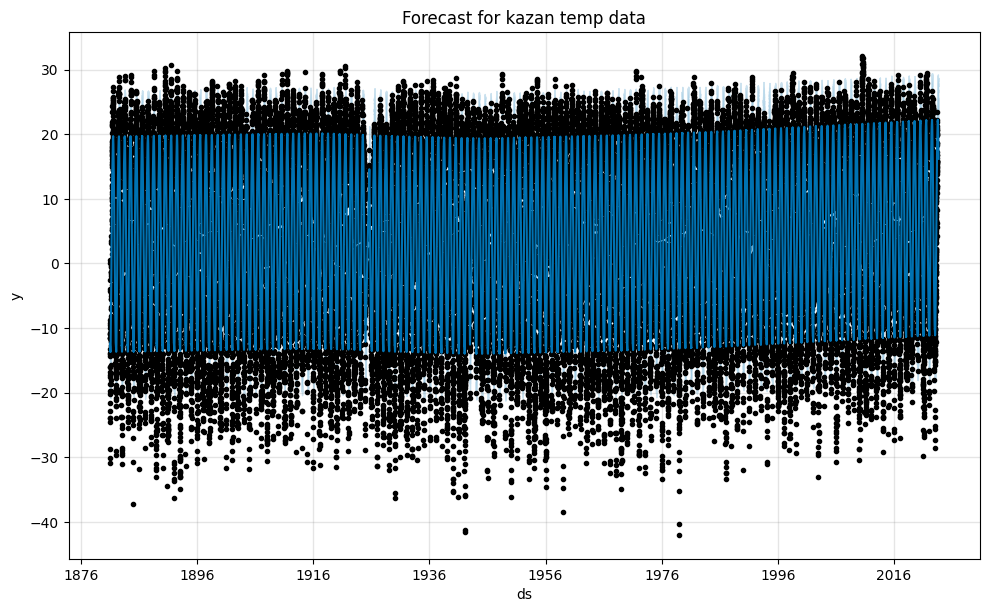

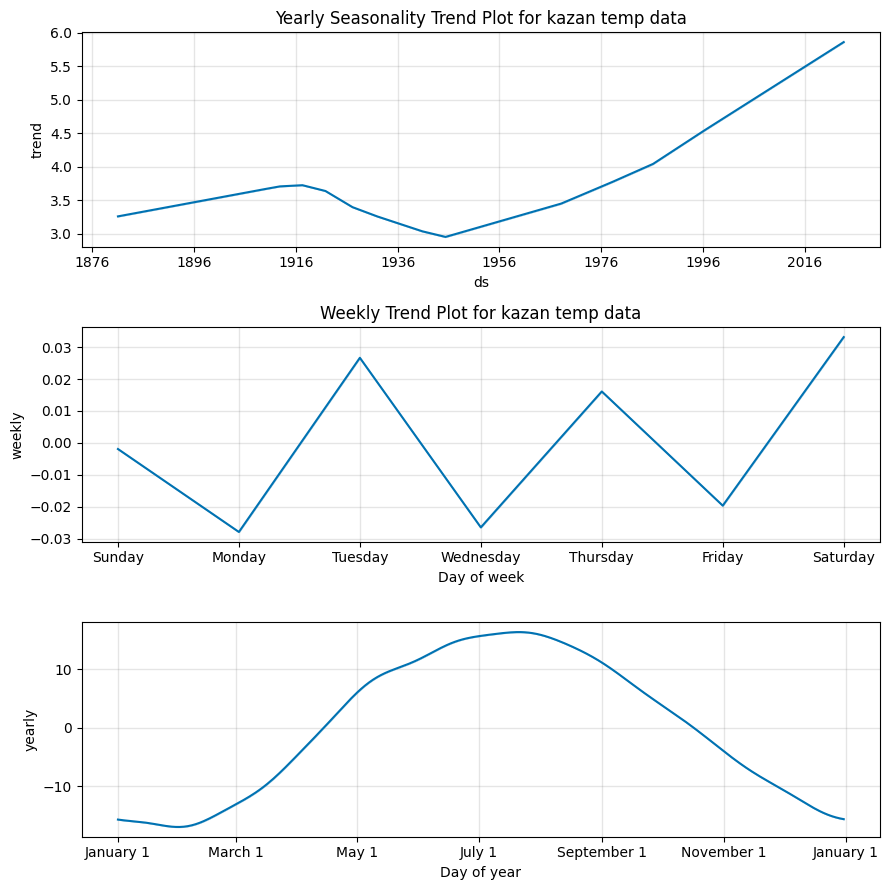

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/pqq16zej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzkn9sirw/e_3gtea0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30775', 'data', 'file=/tmp/tmpzkn9sirw/pqq16zej.json', 'init=/tmp/tmpzkn9sirw/e_3gtea0.json', 'output', 'file=/tmp/tmpzkn9sirw/prophet_model318w5kbd/prophet_model-20250526120418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


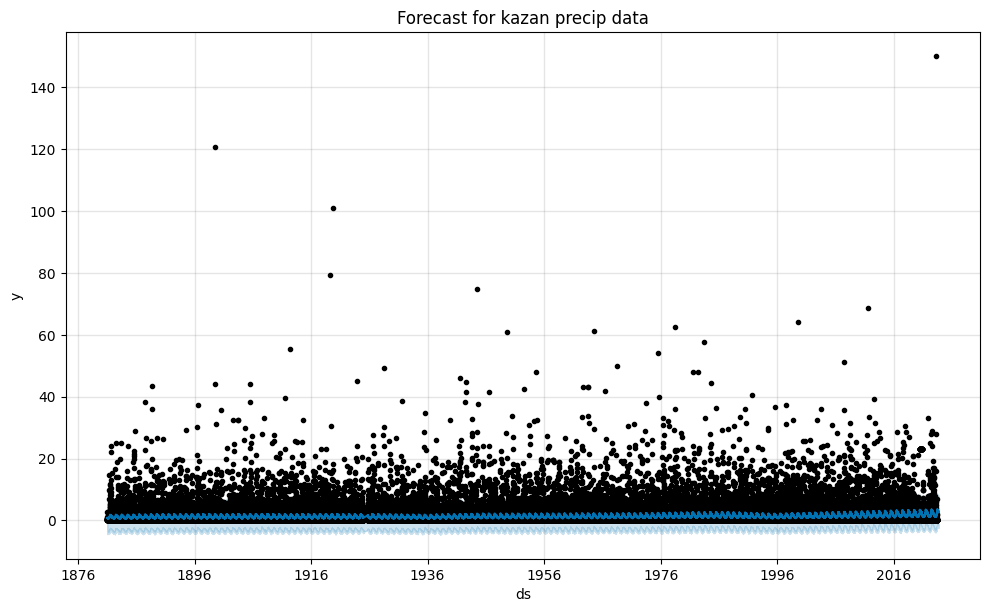

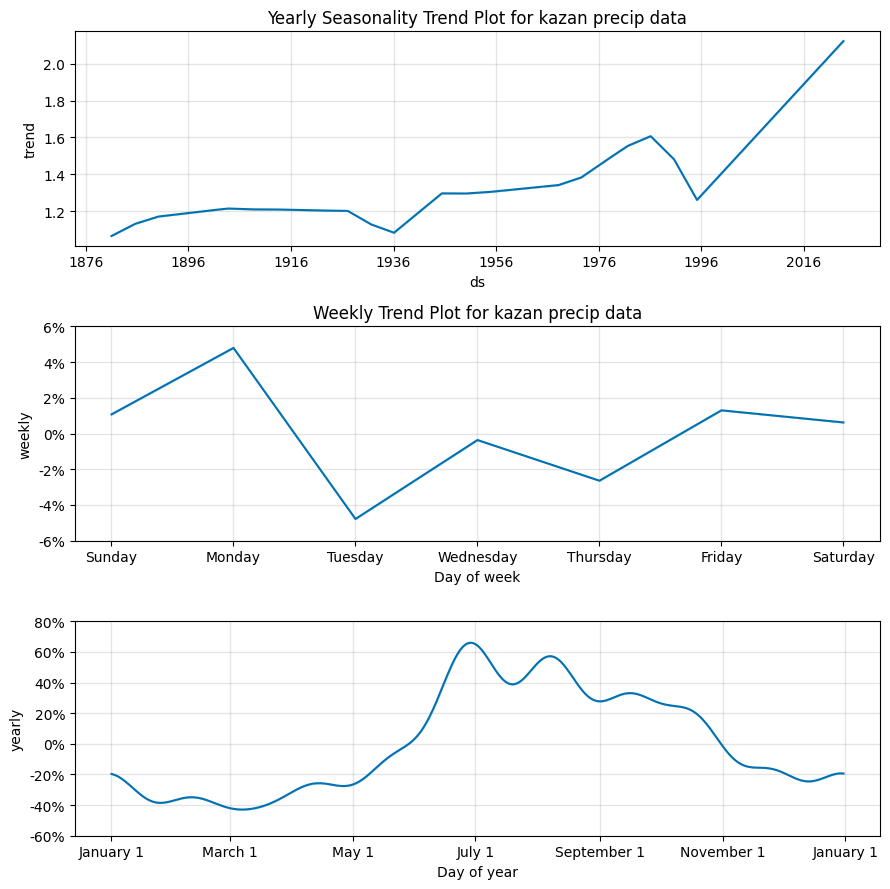

In [29]:
test_forecast = {}

for model_name, model_instance in models.items():
    model_type = model_name.split('_')[1]
    city = model_name.split('_')[0]
    data_name = city+'_'+model_type+'_train'
    model_instance.fit(dataset[data_name])

    future_df = model_instance.make_future_dataframe(periods=90)

    test_forecast[model_name+'forecast'] = model_instance.predict(future_df)
    model_instance.plot(test_forecast[model_name+'forecast']);
    plt.title(f'Forecast for {city} {model_type} data')

    fig = model_instance.plot_components(test_forecast[model_name+'forecast']);
    axes = fig.get_axes()
    axes[0].set_title(f"Yearly Seasonality Trend Plot for {city} {model_type} data")
    axes[1].set_title(f"Weekly Trend Plot for {city} {model_type} data")

    plt.tight_layout()
    plt.show()

Let's run validation on the test set for our models

In [30]:
scores = {}
for modelname in test_forecast.keys():
    dataname = modelname.replace('modelforecast', 'test')
    test_data = dataset[dataname]
    scores[dataname] = float(mean_absolute_error(test_data['y'], test_forecast[modelname]['yhat'][-90:]))

In [31]:
for name, score in scores.items():
    city, model_type, _ = name.split('_')
    print(f"The {model_type} model for {city} has an MAE of {score}")
    print("-----")

The temp model for abidjan has an MAE of 0.5569469121535909
-----
The precip model for abidjan has an MAE of 5.770097418060729
-----
The temp model for toronto has an MAE of 2.1592206209924707
-----
The precip model for toronto has an MAE of 3.402010947199298
-----
The temp model for berlin has an MAE of 2.592248644696377
-----
The precip model for berlin has an MAE of 4.407122962546553
-----
The temp model for kazan has an MAE of 3.323950155868317
-----
The precip model for kazan has an MAE of 2.8782507569918687
-----


Serialize the model as a pickle file.. so we can easily load it for inference

In [32]:
import pickle
import os

os.makedirs('../models/', exist_ok=True)

for model_name, model_instance in models.items():
    with open('../models/'+model_name, 'wb') as M:
        pickle.dump(model_instance, M)

### Recap
We've

- Performed Basic EDA
- Cleaned the data
- Done some sanity checks
- Trained a temperature ts model model for each city and precipitation model for each city
- Ran validation on the test set

## Where to improve
- Try out different models and compare the result. also with models that could explore the relationship between avg temp and precipitation. but we've trained a separate model because we want to answer questions like 'what will the weather be in xx place tomorrow' without providing any input or independent variables.. one of the ways to achieve this is by using a time series model
- Try out different Prophet configuration especially relating to trends.. the default config is using additive models, we could try multiplicative also. In practice the default Prophet might be good but will not necessarily be the best for each of the 8 models that we've built. So we might want to spend some more time on each of the models